In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random
import cv2
import os
import time
from pprint import PrettyPrinter

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


import xml.etree.ElementTree as ET

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pp = PrettyPrinter()
print("device:", device)
torch.backends.cudnn.benchmark = True

device: cuda:0


# Utils

In [6]:
def create_default_boxes():
    fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

    obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

    aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

    fmaps = list(fmap_dims.keys())

    def_boxes = []

    for k, fmap in enumerate(fmaps):
        for i in range(fmap_dims[fmap]):
            for j in range(fmap_dims[fmap]):
                cx = (j + 0.5) / fmap_dims[fmap]
                cy = (i + 0.5) / fmap_dims[fmap]

                for ratio in aspect_ratios[fmap]:
                    def_boxes.append([cx, cy, obj_scales[fmap] * np.sqrt(ratio), obj_scales[fmap] / np.sqrt(ratio)])

                    if ratio == 1.:
                        try:
                            additional_scale = np.sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            
                        except IndexError:
                            additional_scale = 1.
                        def_boxes.append([cx, cy, additional_scale, additional_scale])

    def_boxes = torch.FloatTensor(def_boxes)  # (8732, 4)
    def_boxes.clamp_(0, 1)  # (8732, 4)

    return def_boxes.to(device)


def decode(locs, def_boxes):
    """ Tinhs bouding boxes: offsets ---> center-size coords ---> boundary coords
        Args:
            locs: (8732, 4)         
            def_boxes: (8732, 4)
        Returns:
            boxes: (8732, 4) boundary coords
    """

    boxes = torch.cat((
        def_boxes[:, :2] + locs[:, :2] * def_boxes[:, 2:] * 0.1, #cx, cy
        def_boxes[:, 2:] * torch.exp(locs[:, 2:] * 0.2)), dim=1) #w, h

    boxes[:, :2] -= boxes[:, 2:] / 2  #xmin, ymin
    boxes[:, 2:] += boxes[:, :2]  # xmax, ymax
 
    return boxes


def encode(matches, def_boxes):
    """ Chuyen boxes ve dang offsets
        Args:
            matches: (8732, 4)      boundary coords ---> center-size coords ---> offset
            def_boxes: (8732, 4)
        Return:
            offset: (8732, 4) 
    """
    g_cxcy = (matches[:, :2] + matches[:, 2:]) / 2 #cxcy
    g_wh = matches[:, 2:] - matches[:, :2]
    
    g_hat_cxcy = (g_cxcy - def_boxes[:, :2]) / (def_boxes[:, 2:] * 0.1)
    g_hat_wh = torch.log(g_wh / def_boxes[:, 2:]) / 0.2 

    locs = torch.cat([g_hat_cxcy, g_hat_wh], dim=1)
    
    return locs


def intersect(box_a, box_b):
    """Args:
        box_a : tensor (num_boxes_a, 4)
        box_b : tensor (num_boxes_b, 4)

       Return:
        intersection area: tensor (num_boxes_A, num_boxes_B)
    """
    A = box_a.size(0)
    B = box_b.size(0)

    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2), box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2), box_b[:, 2:].unsqueeze(0).expand(A, B, 2))

    inter = torch.clamp((max_xy - min_xy), min=0)
    
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """
    """ 
    inter = intersect(box_a, box_b) # (num_boxes_a, num_boxes_b)
    area_a = (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]) #(num_boxes_a, )
    area_b = (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]) #(num_boxes_b, )

    area_a.unsqueeze_(1).expand_as(inter)
    area_b.unsqueeze_(0).expand_as(inter)

    union = area_a + area_b - inter

    return inter / union


def cxcy_to_xy(boxes):
    """ Convert center-size coords to boundary coords

    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax

                     
def match(threshhold, truths, def_boxes, labels, locs_t, confs_t, idx):

    """
        Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.

    """

    dbox_xy = cxcy_to_xy(def_boxes) # to xmin ymin xmax ymax (8732, 4)

    overlap = jaccard(truths, dbox_xy) # (num_truth_boxes, 8732)

    best_dbox_overlap, best_dbox_idx = torch.max(overlap, dim=1) # (num_truth_boxes, 1)
    best_truth_overlap, best_truth_idx = torch.max(overlap, dim=0) #(8732, 1)

    best_truth_overlap.index_fill_(0, best_dbox_idx, 2.)  # to ensure best dbox

    for j in range(best_dbox_idx.size(0)):
        best_truth_idx[best_dbox_idx[j]] = j

    matches = truths[best_truth_idx]  # (8732, 4)
    confs = labels[best_truth_idx] + 1 # set label from truth box to each dbox (8732, 1)
    confs[best_truth_overlap < threshhold] = 0 # set background to 0 #(8732, 1)

    # print(truths.shape)
    # print(matches.shape)

    locs = encode(matches, def_boxes)  # (8732, 4)
    locs_t[idx] = locs 
    confs_t[idx] = confs



def show_pred(model, image):
    """Show predictions from model to image
        Args:
            model: change to GPU first
            image(tensor): (1, 3, 300, 300)
    """
    model.eval()
    
    locs, confs, def_boxes = model(image)
    img = image.squeeze(0)
    img = img.permute(1, 2, 0).contiguous().cpu().numpy()
    det = Detect()
    boxes_batch, labels_batch, scores_batch = det.forward(locs, confs, def_boxes) #list of tensor

    for item in range(len(boxes_batch)):
        scores = scores_batch[item]
        boxes = boxes_batch[item]
        labels = labels_batch[item]
        for i in range(scores.size(0)):
            box = boxes[i]
            start = (int(box[0]), int(box[1]))
            end = (int(box[2]), int(box[3]))
            text = "%s:%.1f"%(classes[labels[i]-1][:3], scores[i])
            # print(start, end, classes[labels[i] - 1], scores[i])
            img = cv2.rectangle(img, start, end, (255, 0, 0), 1)
            img = cv2.putText(img, text, start, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        
        plt.imshow(img)
        plt.show()



# Model

In [38]:
class Base(nn.Module):
    """Create first block base on VGG16 and get its pretrained weights
        Thiếu maxpool ở layer4
    """

    def __init__(self):
        super(Base, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # (N, 64, 300, 300)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # (N, 64, 300, 300)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (N, 64, 150, 150)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), #(N, 128, 150, 150)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # (N, 128, 150, 150)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # (N, 128, 75, 75)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # (N, 256, 75, 75)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # (N, 256, 75, 75)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # (N, 256, 75, 75)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True) # (N, 256, 38, 38)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # (N, 512, 38, 38)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 38, 38)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 38, 38)
            nn.ReLU(inplace=True)
            # nn.MaxPool2d(kernel_size=2, stride=2) # (N, 512, 19, 19)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #(N, 512, 19, 19)

        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 19, 19)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 19, 19)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 19, 19)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1) # (N, 512, 19, 19)
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6), # (N, 1024, 19, 19)
            nn.ReLU(inplace=True),
        )
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=1), # (N, 1024, 19, 19)
            nn.ReLU(inplace=True),
        )

        self.load_pretrained_params()

    def forward(self, input):
        #Base
        out = self.layer1(input)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        conv4_3_feat = out
        print(conv4_3_feat.shape)
        out = self.pool4(out)

        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        
        conv7_feat = out

        return conv4_3_feat, conv7_feat 


    def load_pretrained_params(self):

        state_dict = self.state_dict()
        params_keys = list(state_dict.keys())
        

        vgg = torchvision.models.vgg16(pretrained=True)
            
        pretrained_state_dict = vgg.state_dict()
        pretrained_params_keys = list(pretrained_state_dict.keys())

        for i, key in enumerate(params_keys[:-4]):
            state_dict[key] = pretrained_state_dict[pretrained_params_keys[i]]
        print(params_keys)
        print(pretrained_params_keys)
        #Convert fc6, fc7 to convolutional layers
        w_fc6 = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        b_fc6 = pretrained_state_dict['classifier.0.bias'] # (4096,)

        w_fc7 = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        b_fc7 = pretrained_state_dict['classifier.3.bias'] #(4096, )

        # Subsample parameters of fc6, fc7
        w_conv6 = torch.index_select(input=w_fc6, dim=0, index=torch.arange(0, 4096, step=4)) # (1024, 512, 7, 7)
        w_conv6 = torch.index_select(input=w_conv6, dim=2, index=torch.arange(0, 7, step=3)) # (1024, 512, 3, 7)
        w_conv6 = torch.index_select(input=w_conv6, dim=3, index=torch.arange(0, 7, step=3)) #(1024, 512, 3, 3)
        
        b_conv6 = torch.index_select(input=b_fc6, dim=0, index=torch.arange(0, 4096, step=4)) #(1024,)


        w_conv7 = torch.index_select(input=w_fc7, dim=0, index=torch.arange(0, 4096, step=4)) #(1024, 4096, 1, 1)
        w_conv7 = torch.index_select(input=w_conv7, dim=1, index=torch.arange(0, 4096, step=4)) #(1024, 1024, 1, 1)

        b_conv7 = torch.index_select(input=b_fc7, dim=0, index=torch.arange(0, 4096, step=4)) #(1024,)


        state_dict['layer6.0.weight'] = w_conv6
        state_dict['layer6.0.bias'] = b_conv6
        state_dict['layer7.0.weight'] = w_conv7
        state_dict['layer7.0.bias'] = b_conv7

        self.load_state_dict(state_dict)

        print('Loaded pretrained model VGG to Base.') 


In [8]:
class Extras(nn.Module):
    """Extra block with weight initialized by Xavier method"""
    def __init__(self):
        super(Extras, self).__init__()
        self.layer8 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1, padding=0), #(N, 256, 19, 19)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2), # (N, 512, 10, 10)
            nn.ReLU(inplace=True),
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1, padding=0), # (N, 128, 10, 10)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # (N, 256, 5, 5)
            nn.ReLU(inplace=True),
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, padding=0), #(N, 128, 5, 5)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=0), # (N, 256, 3, 3)
            nn.ReLU(inplace=True),
        )
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, padding=0), #(N, 128, 3, 3)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=0), #(N, 256, 1, 1)
            nn.ReLU(inplace=True),
        )

        self.init_params()

    def init_params(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
        
    def forward(self, input):
        #Extras
        out = self.layer8(input)
        conv8_2_feat = out
        out = self.layer9(out)
        conv9_2_feat = out
        out = self.layer10(out)
        conv10_2_feat = out
        conv11_2_feat = self.layer11(out)

        return conv8_2_feat, conv9_2_feat, conv10_2_feat, conv11_2_feat


In [33]:
class Predict(nn.Module):
    """Predict block
        Returns:
            locs(tensor): (batch, 8732, 4): offsets of each boxes
            confs(tensor): (batch, 8732, 21): confidences of each boxes
    """
    def __init__(self, num_classes):
        super(Predict, self).__init__()
        self.num_classes = num_classes
        num_boxes = {'conv4_3':4, 'conv7':6, 'conv8_2':6, 'conv9_2':6, 'conv10_2':4, 'conv11_2':4} #Number of default boxes for each feature

        #Location
        self.loc_conv4_3 = nn.Conv2d(512, num_boxes['conv4_3']*4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, num_boxes['conv7']*4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, num_boxes['conv8_2']*4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, num_boxes['conv9_2']*4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, num_boxes['conv10_2']*4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, num_boxes['conv11_2']*4, kernel_size=3, padding=1)

        #Classify
        self.cl_conv4_3 = nn.Conv2d(512, num_boxes['conv4_3']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, num_boxes['conv7']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, num_boxes['conv8_2']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, num_boxes['conv9_2']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, num_boxes['conv10_2']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, num_boxes['conv11_2']*self.num_classes, kernel_size=3, padding=1)

        self.init_params()

    def init_params(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
    
    
    '''If you just want to reshape tensors, use torch.reshape.
       If you're also concerned about memory usage and want to ensure that the two tensors share the same data, use torch.view.'''
       
    def forward(self, conv4_3_feat, conv7_feat, conv8_2_feat, conv9_2_feat, conv10_2_feat, conv11_2_feat):
        batch_size = conv4_3_feat.shape[0]

        #Location
        loc_conv4_3 = self.loc_conv4_3(conv4_3_feat) # (N, 16, 38, 38)
        loc_conv4_3 = loc_conv4_3.permute(0, 2, 3, 1).contiguous() # (N, 38, 38, 16)
        loc_conv4_3 = loc_conv4_3.view(batch_size, -1, 4) #(N, 5776, 4)
        # print(loc_conv4_3.shape)
        
        loc_conv7 = self.loc_conv7(conv7_feat) #(N, 24, 19, 19)
        loc_conv7 = loc_conv7.permute(0, 2, 3, 1).contiguous() #(N, 19, 19, 24)
        loc_conv7 = loc_conv7.view(batch_size, -1, 4) #(N, 2166, 4)

        loc_conv8_2 = self.loc_conv8_2(conv8_2_feat)
        loc_conv8_2 = loc_conv8_2.permute(0, 2, 3, 1).contiguous()
        loc_conv8_2 = loc_conv8_2.view(batch_size, -1, 4)
        
        loc_conv9_2 = self.loc_conv9_2(conv9_2_feat)
        loc_conv9_2 = loc_conv9_2.permute(0, 2, 3, 1).contiguous()
        loc_conv9_2 = loc_conv9_2.view(batch_size, -1, 4)

        loc_conv10_2 = self.loc_conv10_2(conv10_2_feat)
        loc_conv10_2 = loc_conv10_2.permute(0, 2, 3, 1).contiguous()
        loc_conv10_2 = loc_conv10_2.view(batch_size, -1, 4)

        loc_conv11_2 = self.loc_conv11_2(conv11_2_feat)
        loc_conv11_2 = loc_conv11_2.permute(0, 2, 3, 1).contiguous()
        loc_conv11_2 = loc_conv11_2.view(batch_size, -1, 4)

        #Classification
        cl_conv4_3 = self.cl_conv4_3(conv4_3_feat)  #(N, classes*4, 38, 38)
        cl_conv4_3 = cl_conv4_3.permute(0, 2, 3, 1).contiguous() #(N, 38, 38, classes*4)
        cl_conv4_3 = cl_conv4_3.view(batch_size, -1, self.num_classes) # (N, 5776, classes)

        cl_conv7 = self.cl_conv7(conv7_feat) #(N, classes*6, 19, 19)
        cl_conv7 = cl_conv7.permute(0, 2, 3, 1).contiguous() # (N, 19, 19, classes*6)
        cl_conv7 = cl_conv7.view(batch_size, -1, self.num_classes) # (N, 2166, classes)

        cl_conv8_2 = self.cl_conv8_2(conv8_2_feat)
        cl_conv8_2 = cl_conv8_2.permute(0, 2, 3, 1).contiguous()
        cl_conv8_2 = cl_conv8_2.view(batch_size, -1, self.num_classes)

        cl_conv9_2 = self.cl_conv9_2(conv9_2_feat)
        cl_conv9_2 = cl_conv9_2.permute(0, 2, 3, 1).contiguous()
        cl_conv9_2 = cl_conv9_2.view(batch_size, -1, self.num_classes)

        cl_conv10_2 = self.cl_conv10_2(conv10_2_feat)
        cl_conv10_2 = cl_conv10_2.permute(0, 2, 3, 1).contiguous()
        cl_conv10_2 = cl_conv10_2.view(batch_size, -1, self.num_classes)

        cl_conv11_2 = self.cl_conv11_2(conv11_2_feat)
        cl_conv11_2 = cl_conv11_2.permute(0, 2, 3, 1).contiguous()
        cl_conv11_2 = cl_conv11_2.view(batch_size, -1, self.num_classes)

        
        locs = torch.cat((loc_conv4_3, loc_conv7, loc_conv8_2, loc_conv9_2, loc_conv10_2, loc_conv11_2), dim=1) # dim: the dimention over which the tensors are concatnated
        confs = torch.cat((cl_conv4_3, cl_conv7, cl_conv8_2, cl_conv9_2, cl_conv10_2, cl_conv11_2), dim=1) 

        return locs, confs


In [40]:
class SSD300(nn.Module):
    def __init__(self, num_classes):
        super(SSD300, self).__init__()

        self.num_classes = num_classes

        self.base = Base()
        
        for params in self.base.parameters():
            params.requires_grad = False

        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # for L2 norm
        nn.init.constant_(self.rescale_factors, 20)
            
        self.extras = Extras()
        self.predict = Predict(num_classes)

        self.def_boxes = create_default_boxes()


    def forward(self, image):
        conv4_3_feat, conv7_feat = self.base(image) #(N, 512, 38, 38), (N, 1024, 19, 19)

        # L2 Norm 
        norm = conv4_3_feat.pow(2).sum(dim=1, keepdim=True) #(N, 1, 38, 38)
        norm = torch.sqrt(norm)
        conv4_3_feat = conv4_3_feat / norm #(N, 1, 38, 38)
        conv4_3_feat = conv4_3_feat * self.rescale_factors



        conv8_2_feat, conv9_2_feat, conv10_2_feat, conv11_2_feat = self.extras(conv7_feat)
        locs, confs = self.predict(conv4_3_feat, conv7_feat, conv8_2_feat, conv9_2_feat, conv10_2_feat, conv11_2_feat)


        output = (locs, confs, self.def_boxes)

        return output


In [41]:
image = torch.Tensor(1, 3, 300, 300).to(device)
model(image)

torch.Size([1, 512, 38, 38])
torch.Size([1, 5776, 4])


(tensor([[[-6.7967e-01,  9.2376e-02, -3.0996e-01, -3.8173e-01],
          [ 1.4830e+00,  1.9418e-01, -6.0610e-01, -2.2765e-01],
          [ 1.2122e+00, -9.7598e-01, -4.3774e-01, -1.4646e+00],
          ...,
          [ 9.7752e-03,  5.0948e-03,  4.6501e-04, -1.8003e-03],
          [ 2.6204e-03,  3.7973e-03, -1.0359e-02,  8.8159e-03],
          [-1.0487e-03, -1.3769e-03, -6.7150e-03,  3.2677e-04]]],
        device='cuda:0', grad_fn=<CatBackward>),
 tensor([[[-7.3851e-01, -1.8407e-01,  3.0466e-01,  ..., -8.7384e-01,
           -9.6735e-01,  9.1121e-02],
          [-8.0238e-02,  5.6862e-01, -1.2146e-02,  ...,  2.0757e+00,
           -6.1806e-01, -5.8203e-01],
          [-9.9631e-01, -4.8891e-01,  8.1452e-01,  ...,  5.5647e-01,
            1.6128e-01,  5.0503e-01],
          ...,
          [ 2.5575e-03,  7.2633e-03, -7.6197e-04,  ..., -2.4399e-03,
           -1.4889e-03, -1.0188e-03],
          [-4.5422e-03,  7.7107e-03,  1.5072e-02,  ...,  3.5440e-04,
           -8.6481e-04, -5.9783e-03],


In [10]:
classes = ["aeroplane", "bicycle", "bird",  "boat", "bottle", 
               "bus", "car", "cat", "chair", "cow", "diningtable",
               "dog", "horse", "motorbike", "person", "pottedplant",
               "sheep", "sofa", "train", "tvmonitor"]
               
label_map = {k: v + 1 for v, k in enumerate(classes)}
print(label_map)
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()} 
print(rev_label_map)

{'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}
{1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor', 0: 'background'}


# Loss function

In [19]:
class MultiboxLoss(nn.Module):
    """ 
        1. localization loss
        2. confidence loss for predict class score

        Args:
            threshold: predicted boxes have smaller overlap with groundtruths box will be set to 0
            neg_pos_ratio: using in hard negative mining to decrease number of negative boxes
            alpha:

            predictions(tuple of tensors): output from model(locs, confs, def_boxes)
            targets(list of tensors, one tensor for each image): get from data(boundary coordinates and label)
        Returns:
            loss
    """

    def __init__(self, threshold=0.5, neg_pos_ratio=3, alpha=1):
        super(MultiboxLoss, self).__init__()

        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha
        self.L1Loss = nn.SmoothL1Loss(reduction='sum')
        self.CrossentropyLoss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predictions, targets):
        locs, confs, def_boxes = predictions # (batch, 8732, 4), (batch, 8732, num_classes), (8732, 4)

        batch_size = confs.size(0)
        num_boxes = confs.size(1)
        num_classes = confs.size(2)

        confs_t_labels = torch.LongTensor(batch_size, num_boxes).to(device)
        locs_t = torch.Tensor(batch_size, num_boxes, 4).to(device)
        print(locs_t.shape)
        
        for i in range(batch_size):
            truths = targets[i][:, :-1].to(device) # xmin, ymin, xmax, ymax
            labels = targets[i][:, -1].to(device) # label
            def_boxes = def_boxes.to(device)
            match(self.threshold, truths, def_boxes, labels, locs_t, confs_t_labels, i)

    #Loc_loss
        pos_mask = confs_t_labels > 0  #(batch, 8732)
        n_positive = pos_mask.sum(dim=1) # (batch,)
        # print(n_positive.shape)
        # print(n_positive)
        pos_idx = pos_mask.unsqueeze(2).expand_as(locs_t) #(batch, 8732, 4)

        locs_pred = locs[pos_idx].view(-1, 4)
        locs_t = locs_t[pos_idx].view(-1, 4)

        loc_loss = self.L1Loss(locs_pred, locs_t)
        # print(loc_loss)

    # Conf_loss
        true_classes = confs_t_labels.view(-1).to(device) #(8732)
        predicted_scores = confs.view(-1, num_classes)

        conf_loss_all = self.CrossentropyLoss(predicted_scores, true_classes) # (batch * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, -1) # (batch, 8732)

        # hard negative mining

        n_hard_negative = torch.clamp(n_positive*self.neg_pos_ratio, max=num_boxes) # (batch, )

        conf_loss_pos = conf_loss_all[pos_mask] #(N, )

        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[pos_mask] = 0.  # chuyển loss của positive về 0

        conf_loss_neg, _ = torch.sort(conf_loss_neg, dim=1, descending=True)

        loss_rank = torch.LongTensor(range(num_boxes)).unsqueeze(0).expand_as(conf_loss_neg).to(device) # (batch, 8732)
        hard_negative = loss_rank < n_hard_negative.unsqueeze(1).expand_as(loss_rank)

        conf_loss_hard_neg = conf_loss_neg[hard_negative] 

        conf_loss = (conf_loss_pos.sum() + conf_loss_hard_neg.sum()) 
        # print(conf_loss_pos.sum(),  conf_loss_hard_neg.sum())

        loss = (conf_loss + self.alpha * loc_loss) / n_positive.sum().float()


        return loss


# Data Loader

In [11]:
class VOC2007Detection(Dataset):
    """Get data from root path
        Args:
            root: root path that include trainval set and test set
            classes: list name of each class
            tranform:
            image_set: must be one of {'train', 'val', 'test'}

        Returns:
            image(tensor): (3, 300, 300) qua tranform de phu hop voi mo hinh ssd300
            targets(tensor): (num_boxes, 5): boundary coordinates, label(chua them background):
            difficulties(tensor of 0,1): (num_boxes, ): 1 is difficult, 0 is not 
            filenames(list of strings): (num_boxes, ): list of name for each image

    """
    def __init__(self, root, classes, transform=None, image_set='train'):
        self.root = root
        self.classes = classes
        self.transform = transform
        self.image_set = image_set  

        self.ids = []

        assert self.image_set in {'train', 'val', 'test'}, 'image_set must be one of (train, val, test)'
        
        if self.image_set == 'test':
            id_path = os.path.join(root, 'VOCtest_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/', image_set+'.txt')

            self.anno_path = os.path.join(self.root, 'VOCtest_06-Nov-2007/VOCdevkit/VOC2007/Annotations/%s.xml')
            self.img_path = os.path.join(self.root, 'VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/%s.jpg')
        else:
            id_path = os.path.join(root, 'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/', image_set+'.txt')
            
            self.anno_path = os.path.join(self.root, 'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/%s.xml')
            self.img_path = os.path.join(self.root, 'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/%s.jpg')

        print(id_path)
        
        with open(id_path, 'r') as f:
            for line in f:
                self.ids.append(line.strip())

        
 
    def __getitem__(self, index):
        targets, difficulties, file_names = self.get_annotation(index)
        image = self.get_image(index)

        if self.transform:
            image, targets = self.transform(image, targets)    
            
        return image, targets, difficulties, file_names

    def __len__(self):
        if self.image_set in {'train', 'test'}:
            return len(self.ids)
        else:
            return 500


    def get_annotation(self, index):
        targets = []
        difficulties = []
        file_names = []
        path = self.anno_path % self.ids[index]
        xml = ET.parse(path).getroot()

        for item in xml.iter('filename'):
            filename = item.text
            file_names.append(filename)
        
        for obj in xml.iter('object'):
            difficult = int(obj.find('difficult').text)
            difficulties.append(difficult)
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
        
            bndbox = []
            points = ['xmin', 'ymin', 'xmax', 'ymax']

            for item in points:
                point = int(bbox.find(item).text) - 1
                bndbox.append(point)

            label_id = self.classes.index(name) # without background
            bndbox.append(label_id)  #(xmin, ymin, xmax, ymax, label)

            targets.append(bndbox)

        targets = torch.tensor(targets, dtype=float)
        difficulties = torch.tensor(difficulties, dtype=torch.uint8)

        return targets, difficulties, file_names
    
    def get_image(self, index):
        path = self.img_path % self.ids[index]
        image = cv2.imread(path) #(BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RBG
        
        # image = torch.from_numpy(image).permute(2, 0, 1)

        return image

def collate_fn(batch):
    image = []
    targets = []
    difficulties = []
    file_names = []

    for item in batch:
        image.append(item[0])
        targets.append(item[1])
        difficulties.append(item[2])
        file_names.append(item[3])
       
    image = torch.stack(image, dim=0) #(batch_size, 3, 300, 300)

    return image, targets, difficulties, file_names

# Data transforms

In [12]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, targets=None):
        for t in self.transforms:
            if targets is not None:
                image, targets = t(image, targets)
            else:
                image = t(image)

        return image, targets


class NormalizeCoords(object):
    """Normaize Boundary coordinates to [0, 1]"""
    def __call__(self, image, targets):
        height, weight, channel = image.shape

        targets[:, 0] /= weight
        targets[:, 1] /= height
        targets[:, 2] /= weight
        targets[:, 3] /= height
        
        return image, targets


class Resize(object):
    """Resize each image to 'size' by black two-side padding with non square image"""
    
    def __init__(self, size):
        self.size = size
    def __call__(self, image, targets=None):
        old_h, old_w, channel = image.shape

        padd_top = max((old_w - old_h) // 2, 0)
        padd_left = max((old_h - old_w) // 2, 0)

        image = cv2.copyMakeBorder(image, padd_top, padd_top, padd_left, padd_left, cv2.BORDER_CONSTANT, (0, 0, 0))

        image = cv2.resize(image, (self.size, self.size))
        # image = torch.from_numpy(image).permute(2, 0, 1)
        if targets is not None:
            targets[:, 0] = (targets[:, 0] + padd_left) * self.size / max(old_h, old_w)
            targets[:, 1] = (targets[:, 1] + padd_top) * self.size / max(old_h, old_w)
            targets[:, 2] = (targets[:, 2] + padd_left) * self.size / max(old_h, old_w)
            targets[:, 3] = (targets[:, 3] + padd_top) * self.size / max(old_h, old_w)
        
        return image, targets

class ToTensor(object):
    def __call__(self, image, targets=None):
        to_tensor = transforms.ToTensor()
        return to_tensor(image), targets

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, image, targets=None):
        normalize = transforms.Normalize(mean = self.mean, std = self.std)

        return normalize(image), targets

In [13]:
transform = Compose([
    Resize(300),
    NormalizeCoords(),
    ToTensor(),
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
trainset = VOC2007Detection(root='G:/VOC 2007', classes=classes, transform=transform, image_set='train')
trainloader = DataLoader(dataset=trainset, batch_size=16, shuffle=True, collate_fn=collate_fn)

valset = VOC2007Detection(root='G:/VOC 2007/', classes=classes, transform=transform, image_set='val')
valloader = DataLoader(dataset=valset, batch_size=16, collate_fn=collate_fn)

testset = VOC2007Detection(root='G:/VOC 2007/', classes=classes, transform=transform, image_set='test')
testloader = DataLoader(dataset=testset, batch_size=4, shuffle=True, collate_fn=collate_fn)

G:/VOC 2007\VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/train.txt
G:/VOC 2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/val.txt
G:/VOC 2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/test.txt


# Test data

In [15]:
print(len(trainset), len(valset), len(testset))

2501 500 4952


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


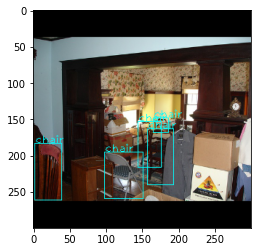

In [17]:
for (images, targets, _, _)  in iter(valloader):
    # print(filenames[0])
    
    image = images[0].permute(1, 2, 0).contiguous().numpy()
    target = targets[0]
    boxes = targets[0][:, :4] * 300
    labels = targets[0][:, 4].int()
    for i in range(boxes.size(0)):  
        start = (int(boxes[i, 0]), int(boxes[i, 1]))
        end = (int(boxes[i, 2]), int(boxes[i, 3]))
        image = cv2.rectangle(image, start, end, (0, 255, 255), 1)
        label = classes[labels[i]]
        image = cv2.putText(image, label, start, cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 255), 1)
    plt.imshow(image)
    plt.show()

    break

# Train model

In [39]:
model = SSD300(21).to(device)
criterion = MultiboxLoss()


['layer1.0.weight', 'layer1.0.bias', 'layer1.2.weight', 'layer1.2.bias', 'layer2.0.weight', 'layer2.0.bias', 'layer2.2.weight', 'layer2.2.bias', 'layer3.0.weight', 'layer3.0.bias', 'layer3.2.weight', 'layer3.2.bias', 'layer3.4.weight', 'layer3.4.bias', 'layer4.0.weight', 'layer4.0.bias', 'layer4.2.weight', 'layer4.2.bias', 'layer4.4.weight', 'layer4.4.bias', 'layer5.0.weight', 'layer5.0.bias', 'layer5.2.weight', 'layer5.2.bias', 'layer5.4.weight', 'layer5.4.bias', 'layer6.0.weight', 'layer6.0.bias', 'layer7.0.weight', 'layer7.0.bias']
['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'fea

In [27]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print('Trainable params = ', trainable)
print('Total parmas = ', total)

Trainable params =  5801582
Total parmas =  26285486


In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [33]:
weights = torch.load('G:/VOC 2007/weights/ssd300_test90.pth')
model.load_state_dict(weights)

<All keys matched successfully>

In [24]:
def train(model, trainloader, valloader, criterion, optimizer, epochs):
    """Args:
            model: have to change to GPU first
            trainloader
            valloader
            criterions: Loss function
            optimizer
            epochs: number epochs u wanna train
    """
    print_freq = 1

    for epoch in range(epochs):
        epoch_loss = 0.0
        val_epoch_loss = 0.0
        
        epoch_start = time.time()
        iter_start = time.time()

        print("---" * 20)
        print('Epoch {} / {}:'.format(epoch+1, epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = valloader

            for i, (images, targets, _, _) in enumerate(dataloader):
                iter_start = time.time()
                
                images = images.to(device)
                targets = [t.to(device) for t in targets]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    
                    outputs = model(images)
                    loss = criterion(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        nn.utils.clip_grad_value_(model.parameters(), clip_value=2.0)
                        optimizer.step()

                        iter_finish = time.time()
                        if (i + 1) % print_freq == 0:
                            time_per_iter = iter_finish - iter_start
                            print('\t\t Time for iter: {:.2f} s, loss: {:.4f}'.format(time_per_iter, loss.item()))

                        epoch_loss += loss.item()

                    else:
                        val_epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(trainloader)
        val_epoch_loss = val_epoch_loss / len(valloader)

        epoch_finish = time.time()
        time_per_epoch = epoch_finish - epoch_start
        print('\t Time for epoch: {:.2f} s, train_loss: {:.4f}, val_loss: {:.4f}'.format(time_per_epoch, epoch_loss, val_epoch_loss))

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), './weights/ssd300_' + str(epoch + 1) + '.pth') 
            print("Save weights on \'./weights/\'.")


In [31]:
train(model, trainloader, valloader, criterion, optimizer, 1)

------------------------------------------------------------
Epoch 1 / 1:
torch.Size([16, 512, 19, 19])
torch.Size([16, 1, 19, 19])
torch.Size([16, 4400, 4])


RuntimeError: The expanded size of the tensor (4400) must match the existing size (8732) at non-singleton dimension 0.  Target sizes: [4400, 4].  Tensor sizes: [8732, 4]

# Test model

In [40]:
class Detect():
    """Args:
            conf_thresh: gia tri score toi thieu cua cac boxes
            top_k: so boxes toi da tren moi image
            nms_thresh: muc overlap toi da cua moi box tren cung class

            locs(tensor): (batch, 8732, 4)
            conf(tensor): (batch, 8732, 21)
            def_boxes(tensor): (8732, 4) default boxes
        
        Returns:
            boxes_per_batch(list of tensors, one tensor for each image): cac boxes thoa man
            labels_per_batch(list of tensors, one tensor for each image): label cua cac box tuong ung
            scores_per_batch(list of tensors, one tensor for each image): score cua cac box tuong ung

    """

    def __init__(self, conf_thresh=0.4, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)
        self.conf_thresh = conf_thresh
        self.top_k = top_k
        self.nms_thresh = nms_thresh

    def forward(self, locs, confs, def_boxes):
        batch_size = confs.size(0)
        num_bbox = confs.size(1)
        num_class = confs.size(2)

        confs = self.softmax(confs) #(batch_size, 8732, num_class)
        # print('confs = ', confs.shape)
        confs_pred = confs.permute(0, 2, 1).contiguous() #(batch_size, num_class, 8732)
        # print(confs_pred.shape)

        # output = torch.zeros(batch_size, num_class, self.top_k, 5)
        boxes_per_batch = list()
        labels_per_batch = list()
        scores_per_batch = list()

        # Xuwr lys tuwngf anhr
        for i in range(batch_size):
            decode_boxes = decode(locs[i], def_boxes) # (8732, 4)
            decode_boxes.clamp_(min=0, max=1)

            confs_score = confs_pred[i].clone().detach() # (num_class, 8732)
            
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            for cl in range(1, num_class):  # Bỏ background
                c_mask = confs_score[cl].gt(self.conf_thresh) # laays nhuwngx thawngf lonws hown conf_thresh #(8732)
                class_scores = confs_score[cl][c_mask] #(x,)
                # print(c_mask.shape)
                if class_scores.size(0) == 0:
                    continue
                
                l_mask = c_mask.unsqueeze(1).expand_as(decode_boxes) # (8732, 4)
                # print(l_mask.shape)
                class_boxes = decode_boxes[l_mask].view(-1, 4) # (x, 4)
  
                indx = torchvision.ops.nms(class_boxes, class_scores, iou_threshold=self.nms_thresh)
                

                image_boxes.append(class_boxes[indx] * 300)
                image_scores.append(class_scores[indx])
                image_labels.append(torch.LongTensor([cl] * len(indx)).to(device))
            


            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0, 0, 1, 1]]))
                image_labels.append(torch.LongTensor([0]))
                image_scores.append(torch.FloatTensor([0]))

            image_boxes = torch.cat(image_boxes, dim=0)
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0)

            if image_scores.size(0) > self.top_k:
                image_scores, indx = torch.sort(image_scores, dim=0, descending=True)

                image_boxes = image_boxes[indx][:self.top_k] 
                image_labels = image_labels[indx][:self.top_k]
                image_scores = image_scores[:self.top_k]

            # print(image_scores, image_labels)
            # print(image_boxes)

        boxes_per_batch.append(image_boxes)
        labels_per_batch.append(image_labels)
        scores_per_batch.append(image_scores)


        return boxes_per_batch, labels_per_batch, scores_per_batch
                

In [ ]:
i = 0
for image, target, _, _ in iter(trainset):
    i += 1
    image = image.unsqueeze(0).to(device)
    show_pred(model, image)
    if i == 5:
        break


In [31]:
def to_txt_file(model, testset):
    """Write all annotions of boxes from model and data to file .txt
    """
    model.eval()

    for image, targets, difficulties, filenames in iter(testset):
        print(difficulties[0])
        image = image.unsqueeze(0).to(device)
        targets = targets.to(device)

        locs, confs, def_boxes = model(image)

        det = Detect()
        boxes, labels, scores = det.forward(locs, confs, def_boxes)
        
        ground_truths_path =  'metrics//Object-Detection-Metrics//groundtruths//' + filenames[0][:-3] +'txt'
        detections_path =  'metrics//Object-Detection-Metrics//detections//' + filenames[0][:-3] +'txt'


        # write ground truths folder
        with open(ground_truths_path, 'w+') as f:
            for i in range(targets.size(0)):
                if difficulties[i] == 1:
                    continue
                target = targets[i]
                box = target[:4] * 300
                box = box.int()
                content = '{} {} {} {} {}\n'.format(classes[target[4].int()], box[0] , box[1], box[2], box[3])
                f.write(content)

        
        with open(detections_path, 'w+') as f:
            for i in range(len(boxes[0])):
                label = labels[0][i].int()
                score = scores[0][i]
                box = boxes[0][i].int()

                content = '{} {} {} {} {} {}\n'.format(classes[label-1], score, box[0], box[1], box[2], box[3])
                f.write(content)
        # show_pred(model, image)
        break

In [32]:
to_txt_file(model, valset)

tensor(0, dtype=torch.uint8)


In [28]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    """ det_boxes: list of tensor (x, 200, 4)
        ...
    """

    num_classes = 21 
    true_images = list()

    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))


    true_images = torch.LongTensor(true_images).to(device) #(n_obj,) tổng số object trên tất cả ảnh trong batch
    true_boxes = torch.cat(true_boxes, dim=0) #(n_obj, 4)
    true_labels = torch.cat(true_labels, dim=0) #(n_obj, )
    true_difficulties = torch.cat(true_difficulties, dim=0)

    det_images = list()

    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))

    det_images = torch.LongTensor(det_images).to(device) #(n_detections, )
    det_boxes = torch.cat(det_boxes, dim=0)
    det_labels = torch.cat(det_labels, dim=0)
    det_scores = torch.cat(det_scores, dim=0)

    average_precisions = torch.zeros((num_classes - 1), dtype=torch.float)

    for c in range(1, num_classes):
        true_class_images = true_images[true_labels == c] #(num_class_object, )
        true_class_boxes = true_boxes[true_labels == c]
        true_class_difficulties = true_difficulties[true_labels == c]
        n_easy_class_object = (1 - true_class_difficulties).sum().item()

        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(device) #(num_class_object, )

        det_class_images = det_images[det_labels == c] # (num_class_detections, )
        det_class_boxes = det_boxes[det_labels == c]
        det_class_scores = det_scores[det_labels == c]

        num_class_detections = det_class_boxes.size(0)

        if num_class_detections == 0:
            continue

        det_class_scores, sorted_idx = torch.sort(det_class_scores, dim=0, descending=True)
        det_class_images = det_class_images[sorted_idx]
        det_class_boxes = det_class_boxes[sorted_idx]

        true_positives = torch.zeros(num_class_detections, dtype=torch.float).to(device)
        false_positives = torch.zeros(num_class_detections, dtype=torch.float).to(device)

        for d in range(num_class_detections):
            this_det_boxes = det_class_boxes[d].unsqueeze(0).to(device) #(1, 4)
            this_image = det_class_images[d]

            object_boxes = true_class_boxes[true_class_images == this_image]
            object_difficulties = true_class_difficulties[true_class_images == this_image]
            # print(this_det_boxes)
            # print(object_boxes)
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            overlaps = jaccard(this_det_boxes, object_boxes) #(1, number_class_object_in_image)
            max_overlaps, idx = torch.max(overlaps.squeeze(0), dim=0)

            original_idx = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][idx]


            if max_overlaps.item() > 0.5:

                if object_difficulties[idx] == 0:

                    if true_class_boxes_detected[original_idx] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_idx] = 1

                    else:
                        false_positives[d] = 1
 
            else:
                false_positives[d] = 1


        cumul_true_positives = torch.cumsum(true_positives, dim=0)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)

        cumul_precision = cumul_true_positives / (cumul_true_positives + cumul_false_positives + 1e-10)
        cumul_recall = cumul_true_positives / n_easy_class_object

        recall_thresholds = torch.arange(start=0, end=1.1, step=0.1).tolist()
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)

        for i, t in enumerate(recall_thresholds):
            recall_above_t = cumul_recall >= t
            if recall_above_t.any():
                precisions[i] = cumul_precision[recall_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()

    mean_average_precisions = average_precisions.mean().item()

    average_precisions = {rev_label_map[c + 1] : ap for c, ap in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precisions

In [32]:
def evaluate(model, testloader):
    model.eval()

    det_boxes = list()
    det_labels = list()
    det_scores = list()

    true_boxes = list()
    true_labels = list()
    true_difficulties = list()

    with torch.no_grad():
        #Check for each batch
        for images, targets, difficulties, _ in testloader:
            images = images.to(device)

            targets = [t.to(device) for t in targets]
            true_boxes_per_batch = [t[:,:4] for t in targets]
            true_labels_per_batch = [t[:,4] for t in targets]

            difficulties = [d.to(device) for d in difficulties]

            pred_locs, pred_confs, def_boxes = model(images)
            det = Detect()
            boxes_per_batch, labels_per_batch, scores_per_batch = det.forward(pred_locs, pred_confs, def_boxes) # (batch, 21, 200, 5)


            det_boxes.extend(boxes_per_batch) 
            det_scores.extend(scores_per_batch)
            det_labels.extend(labels_per_batch)
            print(det_boxes)
            true_boxes.extend(true_boxes_per_batch)
            true_labels.extend(true_labels_per_batch)
            true_difficulties.extend(difficulties)
            print(true_boxes)

            break

        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)
    pp.pprint(APs)

    print('\nMean Average Precisions: %.2f' % mAP)


In [ ]:
evaluate(model, valloader)